# CS/ECE/ISyE 524 - Spr 2018 - HW 10 - Solutions
### Prepared by: Laurent Lessard

# 1. Hexagon construction

The goal is to figure out the optimal geometry of a hexagon such that (1) the hexagon's area is maximized and (2) the hexagon's diameter does not exceed 1. The _diameter_ of the hexagon is the largest distance between any pair of points belonging to the hexagon. There are many different ways to solve this problem. A few suggestions/hints:

- Place one of the vertices at the origin so that you don't need as many decision variables.
- A simple way of computing the area of a hexagon is to split it into four triangles that share a common vertex. The area of the hexagon is then the sum of the areas of the four triangles.
- The optimal solution will look like a legitimate hexagon. It will not be degenerate (no coincident vertices), nor will it be perfectly regular (all sidelengths equal).

Plot a picture of the optimal hexagon.

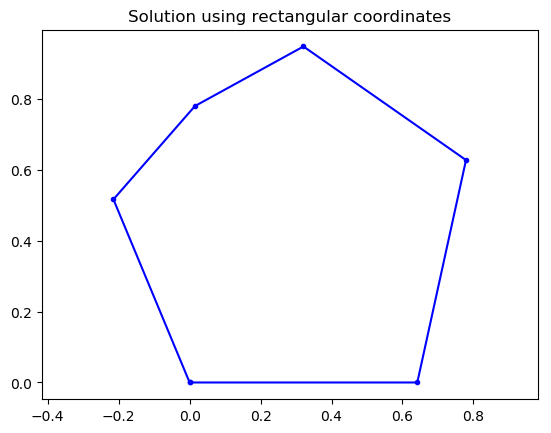

In [2]:
# SOLUTION USING RECTANGULAR COORDINATES

using JuMP, Ipopt

m = Model(solver = IpoptSolver(print_level=0))

# locations of the six vertices.
@variable(m, x[1:6])
@variable(m, y[1:6])

# we will place a vertex at the origin so we only need
# to decide the positions of five other vertices
@constraint(m, x[1] == 0)
@constraint(m, y[1] == 0)
@constraint(m, y[2] == 0) # might as well... (rotational symmetry)

# all pairs of vertices are a distance at most 1 apart (diameter constraint)
for i = 1:6
    for j = i+1:6
        @constraint(m, (x[i]-x[j])^2 + (y[i]-y[j])^2 <= 1 )
    end
end
@NLconstraint(m, prec[i=2:5], x[i]*y[i+1] >= x[i+1]*y[i] )
@NLobjective(m, Max, sum( x[i]*y[i+1] - x[i+1]*y[i] for i = 2:5 ))
            
# use random initializations
srand(0)
setvalue(x[2:6],rand(5))
setvalue(y[3:6],rand(4))
solve(m)            

using PyPlot
X = [getvalue(x); 0]
Y = [getvalue(y); 0]
axis("equal")
plot(X,Y,"b.-")
title("Solution using rectangular coordinates");

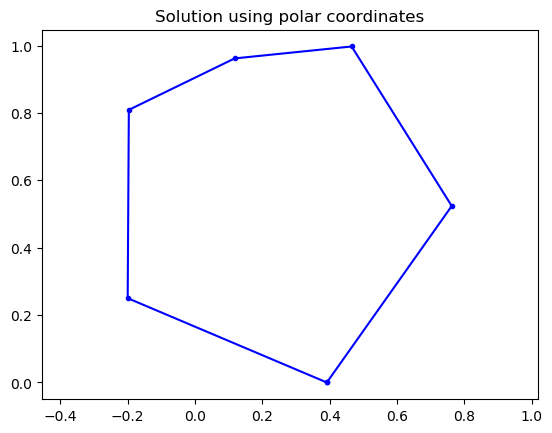

In [4]:
# SOLUTION USING POLAR COORDINATES (with absolute angles)

using JuMP, Ipopt
m = Model(solver = IpoptSolver(print_level=0))

# locations of the six vertices.
@variable(m, r[1:6] >= 0)
@variable(m, 0 <= θ[1:6] <= π)

@constraint(m, θ[1] == 0)  # might as well (rotational symmetry)

# all pairs of vertices are a distance at most 1 apart (diameter constraint)
# make use of the cosine law.
for i = 1:6
    for j = i+1:6
        @NLconstraint(m, r[i]^2 + r[j]^2 - 2*r[i]*r[j]*cos(θ[i]-θ[j]) <= 1 )
    end
end

# impose angle ordering
for i = 1:5
    @constraint(m, θ[i] <= θ[i+1])
end

@NLobjective(m, Max, sum( .5*r[i]*r[i+1]*sin(θ[i+1]-θ[i]) for i = 1:5 ) + .5*r[6]*r[1]*sin(θ[1]-θ[6]) )

solve(m)

using PyPlot
R = getvalue([r; r[1]])
Θ = getvalue([θ; θ[1]])
axis("equal")
plot(R.*cos.(Θ),R.*sin.(Θ),"b.-")
title("Solution using polar coordinates");

# 2. Fertilizer influence model

A series of experiments is conducted to determine the effect of a particular fertilizer on wheat crop yield. Here are the results:

| fertilizer rate ($x$) | crop yield ($y$) |
|:---------------------:|:----------------:|
|      -5               |      127         |
|      -3               |      151         |
|      -1               |      379         |
|       1               |      421         |
|       3               |      460         |
|       5               |      426         |

Such situations typically involve some sort of _diminishing returns_. So there is a limit to how much the fertilizer can boost the yield. A popular model for this relationship is the following:

$$
y = k_1 + k_2 \exp(k_3 x)
$$

Use nonlinear least squares to determine the values of $(k_1,k_2,k_3)$ that provide the best fit to the data. We are expecting coefficients in the neighborhood of $(500,-200,-1)$. To display your result, produce a plot of the original data points and the best-fit curve.

In [5]:
using JuMP, Ipopt

x =     [ -5  -3  -1   1   3   5]
ymeas = [127 151 379 421 460 426]
N = length(x)

m = Model(solver = IpoptSolver(print_level=0))

@variable(m, k[1:3])
@NLexpression(m, yfit[i=1:N], k[1] + k[2]*exp(k[3]*x[i]) )

@NLobjective(m, Min, sum( (yfit[i]-ymeas[i])^2 for i=1:N ) )

setvalue(k, [500,-200,-1])

solve(m)
K = getvalue(k)

3-element Array{Float64,1}:
  523.306   
 -156.948   
   -0.199665

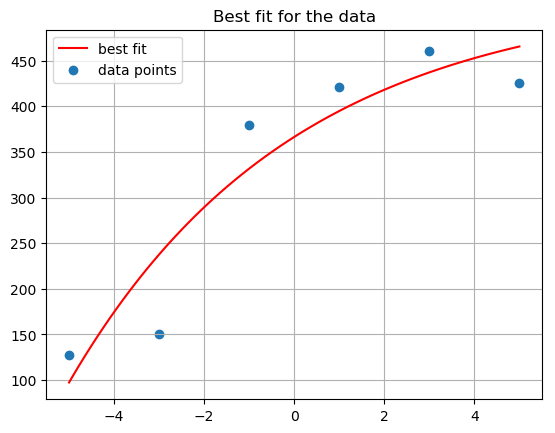

In [8]:
# Plot the data and the best-fit curve

using PyPlot
xv = linspace(-5,5,100)
yv = K[1] + K[2]*exp.(K[3]*xv)
scatter(x,ymeas, label="data points")
plot(xv,yv, "r-", label="best fit")
grid()
legend(loc="best"); title("Best fit for the data");